In [4]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [5]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [6]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [32]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 1




In [33]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [34]:
configs.specifier = specifier
configs.data_name = data_name



In [35]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:1'

# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [11]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [12]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [14]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,Grade_1,Grade_4,Sex_2,Grade_3,FIX_DURATION,FIX_Y,IQ,Age,Grade_2,Grade_6,FIX_X,Sex_1,Grade_5
0,0,1,0,0,219.0,531.8,23,10,0,0,177.3,1,0
1,0,1,0,0,247.0,545.2,23,10,0,0,200.5,1,0
2,0,1,0,0,261.0,542.4,23,10,0,0,282.7,1,0
3,0,1,0,0,268.0,545.5,23,10,0,0,358.1,1,0
4,0,1,0,0,129.0,536.3,23,10,0,0,392.8,1,0


In [17]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [18]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [19]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [21]:
np.unique(y_org.Group.values)

array([1, 3])

In [22]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (199277, 13)


In [23]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [24]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 1.   , 0.   , ..., 0.043, 1.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.06 , 1.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.121, 1.   , 0.   ],
                                 ...,
                                 [0.   , 0.   , 1.   , ..., 0.484, 0.   , 0.   ],
                                 [0.   , 0.   , 1.   , ..., 0.609, 0.   , 0.   ],
                                 [0.   , 0.   , 1.   , ..., 0.644, 0.   , 0.   ]]),
                          'x_test': array([[0.   , 1.   , 0.   , ..., 0.203, 1.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.667, 1.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.463, 1.   , 0.   ],
                                 ...,
                                 [0.   , 0.   , 1.   , ..., 0.192, 0.   , 0.   ],
        

## Load the tuned parameters

In [31]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [ ]:


# specifier

In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )



In [36]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [38]:

x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [53]:

class_names = ['Norm', 'Dyslexic']




In [40]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl




In [42]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [43]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [ ]:


mdl.fit(x_train, y_train)




 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2371     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13290D-01    |proj g|=  1.88613D-01

At iterate    1    f=  6.26201D-01    |proj g|=  2.81797D-02

At iterate    2    f=  6.11701D-01    |proj g|=  2.49163D-02

At iterate    3    f=  5.50086D-01    |proj g|=  3.43264D-02

At iterate    4    f=  5.44027D-01    |proj g|=  7.95331D-03

At iterate    5    f=  5.43023D-01    |proj g|=  8.80789D-03

At iterate    6    f=  5.39554D-01    |proj g|=  2.43888D-03

At iterate    7    f=  5.37867D-01    |proj g|=  2.74948D-03

At iterate    8    f=  5.34790D-01    |proj g|=  2.02561D-03

At iterate    9    f=  5.31399D-01    |proj g|=  5.38156D-03

At iterate   10    f=  5.30299D-01    |proj g|=  8.19522D-03

At iterate   11    f=  5.29429D-01    |proj g|=  4.44886D-03

At iterate   12    f=  5.28090D-01    |proj g|=  2.55693D-03

At iterate   13    f=  5.2


At iterate  130    f=  4.37707D-01    |proj g|=  1.49790D-02

At iterate  131    f=  4.36430D-01    |proj g|=  5.94471D-03

At iterate  132    f=  4.35482D-01    |proj g|=  7.03025D-03

At iterate  133    f=  4.34549D-01    |proj g|=  2.70379D-02

At iterate  134    f=  4.33351D-01    |proj g|=  1.01634D-02

At iterate  135    f=  4.32805D-01    |proj g|=  6.76858D-03

At iterate  136    f=  4.32319D-01    |proj g|=  6.57093D-03

At iterate  137    f=  4.31779D-01    |proj g|=  6.34195D-03

At iterate  138    f=  4.30945D-01    |proj g|=  1.01001D-02

At iterate  139    f=  4.30130D-01    |proj g|=  9.48154D-03

At iterate  140    f=  4.27446D-01    |proj g|=  1.64694D-02

At iterate  141    f=  4.26973D-01    |proj g|=  1.10515D-02

At iterate  142    f=  4.26519D-01    |proj g|=  1.20812D-02

At iterate  143    f=  4.26205D-01    |proj g|=  7.66870D-03

At iterate  144    f=  4.25844D-01    |proj g|=  7.20239D-03

At iterate  145    f=  4.25644D-01    |proj g|=  7.54815D-03

At iter


At iterate  263    f=  3.55494D-01    |proj g|=  5.26650D-03

At iterate  264    f=  3.55358D-01    |proj g|=  4.12893D-03

At iterate  265    f=  3.55115D-01    |proj g|=  4.44057D-03

At iterate  266    f=  3.54544D-01    |proj g|=  8.52484D-03

At iterate  267    f=  3.53589D-01    |proj g|=  1.00949D-02

At iterate  268    f=  3.53284D-01    |proj g|=  1.46528D-02

At iterate  269    f=  3.52560D-01    |proj g|=  9.61189D-03

At iterate  270    f=  3.52260D-01    |proj g|=  6.53245D-03

At iterate  271    f=  3.52117D-01    |proj g|=  4.74372D-03

At iterate  272    f=  3.52017D-01    |proj g|=  5.08021D-03

At iterate  273    f=  3.51818D-01    |proj g|=  4.31720D-03

At iterate  274    f=  3.50726D-01    |proj g|=  8.20952D-03

At iterate  275    f=  3.50067D-01    |proj g|=  9.19042D-03

At iterate  276    f=  3.49529D-01    |proj g|=  8.13586D-03

At iterate  277    f=  3.47999D-01    |proj g|=  5.89699D-03

At iterate  278    f=  3.47533D-01    |proj g|=  4.74988D-03

At iter


At iterate  396    f=  2.75741D-01    |proj g|=  5.96825D-03

At iterate  397    f=  2.75456D-01    |proj g|=  1.43526D-02

At iterate  398    f=  2.74982D-01    |proj g|=  6.77488D-03

At iterate  399    f=  2.74675D-01    |proj g|=  6.67809D-03

At iterate  400    f=  2.74142D-01    |proj g|=  7.43050D-03

At iterate  401    f=  2.73619D-01    |proj g|=  5.97197D-03

At iterate  402    f=  2.72698D-01    |proj g|=  5.92962D-03

At iterate  403    f=  2.72061D-01    |proj g|=  1.02263D-02

At iterate  404    f=  2.71437D-01    |proj g|=  6.51258D-03

At iterate  405    f=  2.71012D-01    |proj g|=  6.42533D-03

At iterate  406    f=  2.70819D-01    |proj g|=  1.36747D-02

At iterate  407    f=  2.70400D-01    |proj g|=  6.47699D-03

At iterate  408    f=  2.69757D-01    |proj g|=  9.23110D-03

At iterate  409    f=  2.69206D-01    |proj g|=  1.26450D-02

At iterate  410    f=  2.69026D-01    |proj g|=  2.53181D-02

At iterate  411    f=  2.68213D-01    |proj g|=  9.54705D-03

At iter


At iterate  529    f=  2.32200D-01    |proj g|=  6.22268D-03

At iterate  530    f=  2.31876D-01    |proj g|=  5.22319D-03

At iterate  531    f=  2.31711D-01    |proj g|=  4.82776D-03

At iterate  532    f=  2.31588D-01    |proj g|=  3.53091D-03

At iterate  533    f=  2.31466D-01    |proj g|=  3.61855D-03

At iterate  534    f=  2.31046D-01    |proj g|=  5.04715D-03

At iterate  535    f=  2.30953D-01    |proj g|=  6.81757D-03

At iterate  536    f=  2.30755D-01    |proj g|=  4.85763D-03

At iterate  537    f=  2.30594D-01    |proj g|=  3.40470D-03

At iterate  538    f=  2.30394D-01    |proj g|=  3.67035D-03

At iterate  539    f=  2.30103D-01    |proj g|=  8.93264D-03

At iterate  540    f=  2.29856D-01    |proj g|=  9.45395D-03

At iterate  541    f=  2.29594D-01    |proj g|=  5.94320D-03

At iterate  542    f=  2.29407D-01    |proj g|=  3.74966D-03

At iterate  543    f=  2.29198D-01    |proj g|=  4.92818D-03

At iterate  544    f=  2.28654D-01    |proj g|=  5.81410D-03

At iter


At iterate  662    f=  2.00415D-01    |proj g|=  4.80877D-03

At iterate  663    f=  2.00139D-01    |proj g|=  5.42871D-03

At iterate  664    f=  1.99967D-01    |proj g|=  4.56123D-03

At iterate  665    f=  1.99825D-01    |proj g|=  1.36230D-02

At iterate  666    f=  1.99549D-01    |proj g|=  7.39139D-03

At iterate  667    f=  1.99359D-01    |proj g|=  4.71712D-03

At iterate  668    f=  1.99145D-01    |proj g|=  4.82582D-03

At iterate  669    f=  1.98941D-01    |proj g|=  5.37481D-03

At iterate  670    f=  1.98439D-01    |proj g|=  5.69767D-03

At iterate  671    f=  1.98180D-01    |proj g|=  9.56802D-03

At iterate  672    f=  1.97866D-01    |proj g|=  5.17415D-03

At iterate  673    f=  1.97711D-01    |proj g|=  7.24393D-03

At iterate  674    f=  1.97532D-01    |proj g|=  3.95307D-03

At iterate  675    f=  1.97325D-01    |proj g|=  4.30677D-03

At iterate  676    f=  1.96939D-01    |proj g|=  4.98132D-03

At iterate  677    f=  1.96772D-01    |proj g|=  1.26703D-02

At iter


At iterate  795    f=  1.79177D-01    |proj g|=  3.63310D-03

At iterate  796    f=  1.79061D-01    |proj g|=  6.67419D-03

At iterate  797    f=  1.78961D-01    |proj g|=  3.28846D-03

At iterate  798    f=  1.78857D-01    |proj g|=  2.36349D-03

At iterate  799    f=  1.78822D-01    |proj g|=  3.98278D-03

At iterate  800    f=  1.78745D-01    |proj g|=  3.43550D-03

At iterate  801    f=  1.78489D-01    |proj g|=  3.47239D-03

At iterate  802    f=  1.78278D-01    |proj g|=  7.14131D-03

At iterate  803    f=  1.78166D-01    |proj g|=  7.34576D-03

At iterate  804    f=  1.78049D-01    |proj g|=  2.81402D-03

At iterate  805    f=  1.78002D-01    |proj g|=  3.18739D-03

At iterate  806    f=  1.77873D-01    |proj g|=  4.56907D-03

At iterate  807    f=  1.77665D-01    |proj g|=  4.59655D-03

At iterate  808    f=  1.77583D-01    |proj g|=  7.41146D-03

At iterate  809    f=  1.77328D-01    |proj g|=  2.78613D-03

At iterate  810    f=  1.77213D-01    |proj g|=  2.65778D-03

At iter


At iterate  928    f=  1.64955D-01    |proj g|=  2.62792D-03

At iterate  929    f=  1.64906D-01    |proj g|=  1.84524D-03

At iterate  930    f=  1.64856D-01    |proj g|=  2.53385D-03

At iterate  931    f=  1.64832D-01    |proj g|=  3.84484D-03

At iterate  932    f=  1.64805D-01    |proj g|=  3.01924D-03

At iterate  933    f=  1.64740D-01    |proj g|=  2.09939D-03

At iterate  934    f=  1.64681D-01    |proj g|=  2.00013D-03

At iterate  935    f=  1.64583D-01    |proj g|=  3.16769D-03

At iterate  936    f=  1.64516D-01    |proj g|=  4.24712D-03

At iterate  937    f=  1.64430D-01    |proj g|=  1.93718D-03

At iterate  938    f=  1.64372D-01    |proj g|=  1.76293D-03

At iterate  939    f=  1.64312D-01    |proj g|=  1.90034D-03

At iterate  940    f=  1.64244D-01    |proj g|=  2.95644D-03

At iterate  941    f=  1.64186D-01    |proj g|=  2.55267D-03

At iterate  942    f=  1.64122D-01    |proj g|=  2.40344D-03

At iterate  943    f=  1.64098D-01    |proj g|=  4.64612D-03

At iter


At iterate 1061    f=  1.59502D-01    |proj g|=  1.48831D-03

At iterate 1062    f=  1.59482D-01    |proj g|=  1.01184D-03

At iterate 1063    f=  1.59460D-01    |proj g|=  1.37241D-03

At iterate 1064    f=  1.59440D-01    |proj g|=  4.54550D-03

At iterate 1065    f=  1.59406D-01    |proj g|=  1.68403D-03

At iterate 1066    f=  1.59383D-01    |proj g|=  1.06373D-03

At iterate 1067    f=  1.59361D-01    |proj g|=  1.31742D-03

At iterate 1068    f=  1.59354D-01    |proj g|=  4.13223D-03

At iterate 1069    f=  1.59328D-01    |proj g|=  1.57404D-03

At iterate 1070    f=  1.59313D-01    |proj g|=  2.08781D-03

At iterate 1071    f=  1.59286D-01    |proj g|=  2.55410D-03

At iterate 1072    f=  1.59245D-01    |proj g|=  2.23594D-03

At iterate 1073    f=  1.59233D-01    |proj g|=  4.69244D-03

At iterate 1074    f=  1.59175D-01    |proj g|=  1.23070D-03

At iterate 1075    f=  1.59159D-01    |proj g|=  1.29672D-03

At iterate 1076    f=  1.59141D-01    |proj g|=  2.21858D-03

At iter


At iterate 1194    f=  1.56332D-01    |proj g|=  4.21332D-03

At iterate 1195    f=  1.56294D-01    |proj g|=  1.34377D-03

At iterate 1196    f=  1.56281D-01    |proj g|=  1.01588D-03

At iterate 1197    f=  1.56271D-01    |proj g|=  2.35187D-03

At iterate 1198    f=  1.56255D-01    |proj g|=  1.59922D-03

At iterate 1199    f=  1.56213D-01    |proj g|=  1.86922D-03

At iterate 1200    f=  1.56181D-01    |proj g|=  2.19872D-03

At iterate 1201    f=  1.56132D-01    |proj g|=  2.04459D-03

At iterate 1202    f=  1.56122D-01    |proj g|=  5.60353D-03

At iterate 1203    f=  1.56083D-01    |proj g|=  1.79165D-03

At iterate 1204    f=  1.56069D-01    |proj g|=  1.33863D-03

At iterate 1205    f=  1.56046D-01    |proj g|=  1.78438D-03

At iterate 1206    f=  1.56020D-01    |proj g|=  1.64736D-03

At iterate 1207    f=  1.56004D-01    |proj g|=  3.83835D-03

At iterate 1208    f=  1.55975D-01    |proj g|=  1.77278D-03

At iterate 1209    f=  1.55948D-01    |proj g|=  1.43286D-03

At iter


At iterate 1327    f=  1.53261D-01    |proj g|=  1.33620D-03

At iterate 1328    f=  1.53249D-01    |proj g|=  3.56415D-03

At iterate 1329    f=  1.53228D-01    |proj g|=  2.49674D-03

At iterate 1330    f=  1.53193D-01    |proj g|=  1.41720D-03

At iterate 1331    f=  1.53167D-01    |proj g|=  1.48461D-03

At iterate 1332    f=  1.53155D-01    |proj g|=  2.92173D-03

At iterate 1333    f=  1.53131D-01    |proj g|=  1.65342D-03

At iterate 1334    f=  1.53116D-01    |proj g|=  1.31531D-03

At iterate 1335    f=  1.53095D-01    |proj g|=  1.45442D-03

At iterate 1336    f=  1.53065D-01    |proj g|=  1.29306D-03

At iterate 1337    f=  1.53048D-01    |proj g|=  2.70899D-03

At iterate 1338    f=  1.53013D-01    |proj g|=  1.43680D-03

At iterate 1339    f=  1.52989D-01    |proj g|=  1.90095D-03

At iterate 1340    f=  1.52965D-01    |proj g|=  4.18319D-03

At iterate 1341    f=  1.52940D-01    |proj g|=  1.59848D-03

At iterate 1342    f=  1.52922D-01    |proj g|=  1.12652D-03

At iter


At iterate 1460    f=  1.50947D-01    |proj g|=  4.35245D-03

At iterate 1461    f=  1.50922D-01    |proj g|=  1.04163D-03

At iterate 1462    f=  1.50909D-01    |proj g|=  8.29978D-04

At iterate 1463    f=  1.50888D-01    |proj g|=  1.26684D-03

At iterate 1464    f=  1.50876D-01    |proj g|=  4.14662D-03

At iterate 1465    f=  1.50851D-01    |proj g|=  1.82728D-03

At iterate 1466    f=  1.50836D-01    |proj g|=  9.16606D-04

At iterate 1467    f=  1.50825D-01    |proj g|=  3.10011D-03

At iterate 1468    f=  1.50812D-01    |proj g|=  1.37965D-03

At iterate 1469    f=  1.50803D-01    |proj g|=  1.34418D-03

At iterate 1470    f=  1.50787D-01    |proj g|=  2.12808D-03

At iterate 1471    f=  1.50771D-01    |proj g|=  1.60241D-03

At iterate 1472    f=  1.50752D-01    |proj g|=  2.86172D-03

At iterate 1473    f=  1.50733D-01    |proj g|=  1.61632D-03

At iterate 1474    f=  1.50718D-01    |proj g|=  1.31029D-03

At iterate 1475    f=  1.50699D-01    |proj g|=  1.43973D-03

At iter


At iterate 1593    f=  1.48996D-01    |proj g|=  2.07566D-03

At iterate 1594    f=  1.48983D-01    |proj g|=  1.04079D-03

At iterate 1595    f=  1.48974D-01    |proj g|=  7.57958D-04

At iterate 1596    f=  1.48957D-01    |proj g|=  1.74089D-03

At iterate 1597    f=  1.48921D-01    |proj g|=  2.71792D-03

At iterate 1598    f=  1.48890D-01    |proj g|=  2.24909D-03

At iterate 1599    f=  1.48857D-01    |proj g|=  2.04581D-03

At iterate 1600    f=  1.48838D-01    |proj g|=  1.05702D-03

At iterate 1601    f=  1.48814D-01    |proj g|=  1.80389D-03

At iterate 1602    f=  1.48788D-01    |proj g|=  2.16430D-03

At iterate 1603    f=  1.48765D-01    |proj g|=  1.36129D-03

At iterate 1604    f=  1.48753D-01    |proj g|=  1.48263D-03

At iterate 1605    f=  1.48746D-01    |proj g|=  3.30861D-03

At iterate 1606    f=  1.48735D-01    |proj g|=  1.71552D-03

At iterate 1607    f=  1.48718D-01    |proj g|=  1.44777D-03

At iterate 1608    f=  1.48701D-01    |proj g|=  2.07515D-03

At iter


At iterate 1726    f=  1.46927D-01    |proj g|=  2.77770D-03

At iterate 1727    f=  1.46910D-01    |proj g|=  2.00498D-03

At iterate 1728    f=  1.46899D-01    |proj g|=  1.13335D-03

At iterate 1729    f=  1.46890D-01    |proj g|=  1.04515D-03

At iterate 1730    f=  1.46884D-01    |proj g|=  2.22894D-03

At iterate 1731    f=  1.46876D-01    |proj g|=  1.89677D-03

At iterate 1732    f=  1.46851D-01    |proj g|=  1.23851D-03

At iterate 1733    f=  1.46844D-01    |proj g|=  1.02370D-03

At iterate 1734    f=  1.46826D-01    |proj g|=  1.30563D-03

At iterate 1735    f=  1.46819D-01    |proj g|=  1.67772D-03

At iterate 1736    f=  1.46810D-01    |proj g|=  9.38834D-04

At iterate 1737    f=  1.46796D-01    |proj g|=  8.84540D-04

At iterate 1738    f=  1.46786D-01    |proj g|=  1.30493D-03

At iterate 1739    f=  1.46772D-01    |proj g|=  2.41600D-03

At iterate 1740    f=  1.46763D-01    |proj g|=  1.87502D-03

At iterate 1741    f=  1.46753D-01    |proj g|=  8.62337D-04

At iter


At iterate 1859    f=  1.45615D-01    |proj g|=  1.95115D-03

At iterate 1860    f=  1.45608D-01    |proj g|=  9.71282D-04

At iterate 1861    f=  1.45601D-01    |proj g|=  1.04725D-03

At iterate 1862    f=  1.45589D-01    |proj g|=  1.33206D-03

At iterate 1863    f=  1.45576D-01    |proj g|=  1.87622D-03

At iterate 1864    f=  1.45569D-01    |proj g|=  1.82834D-03

At iterate 1865    f=  1.45555D-01    |proj g|=  7.43265D-04

At iterate 1866    f=  1.45550D-01    |proj g|=  6.18721D-04

At iterate 1867    f=  1.45541D-01    |proj g|=  7.36301D-04

At iterate 1868    f=  1.45533D-01    |proj g|=  2.52524D-03

At iterate 1869    f=  1.45525D-01    |proj g|=  8.21758D-04

At iterate 1870    f=  1.45517D-01    |proj g|=  9.12400D-04

At iterate 1871    f=  1.45509D-01    |proj g|=  1.18271D-03

At iterate 1872    f=  1.45506D-01    |proj g|=  2.84315D-03

At iterate 1873    f=  1.45495D-01    |proj g|=  7.56872D-04

At iterate 1874    f=  1.45491D-01    |proj g|=  6.65885D-04

At iter


At iterate 1992    f=  1.44926D-01    |proj g|=  1.63600D-03

At iterate 1993    f=  1.44923D-01    |proj g|=  2.91914D-03

At iterate 1994    f=  1.44913D-01    |proj g|=  2.16169D-03

At iterate 1995    f=  1.44903D-01    |proj g|=  1.10051D-03

At iterate 1996    f=  1.44891D-01    |proj g|=  8.97096D-04

At iterate 1997    f=  1.44882D-01    |proj g|=  8.32967D-04

At iterate 1998    f=  1.44878D-01    |proj g|=  3.61432D-03

At iterate 1999    f=  1.44862D-01    |proj g|=  1.27044D-03

At iterate 2000    f=  1.44856D-01    |proj g|=  9.56663D-04

At iterate 2001    f=  1.44850D-01    |proj g|=  7.10936D-04

At iterate 2002    f=  1.44844D-01    |proj g|=  2.40977D-03

At iterate 2003    f=  1.44838D-01    |proj g|=  1.47224D-03

At iterate 2004    f=  1.44825D-01    |proj g|=  7.53152D-04

At iterate 2005    f=  1.44819D-01    |proj g|=  9.41620D-04

At iterate 2006    f=  1.44806D-01    |proj g|=  8.20998D-04

At iterate 2007    f=  1.44804D-01    |proj g|=  1.65244D-03

At iter


At iterate 2125    f=  1.43932D-01    |proj g|=  8.94182D-04

At iterate 2126    f=  1.43925D-01    |proj g|=  1.34645D-03

At iterate 2127    f=  1.43921D-01    |proj g|=  4.43766D-03

At iterate 2128    f=  1.43910D-01    |proj g|=  9.36738D-04

At iterate 2129    f=  1.43905D-01    |proj g|=  5.85990D-04

At iterate 2130    f=  1.43898D-01    |proj g|=  1.46412D-03

At iterate 2131    f=  1.43888D-01    |proj g|=  1.81519D-03

At iterate 2132    f=  1.43886D-01    |proj g|=  1.39954D-03

At iterate 2133    f=  1.43879D-01    |proj g|=  8.09457D-04

At iterate 2134    f=  1.43874D-01    |proj g|=  5.55581D-04

At iterate 2135    f=  1.43864D-01    |proj g|=  4.79293D-04

At iterate 2136    f=  1.43857D-01    |proj g|=  1.21806D-03

At iterate 2137    f=  1.43849D-01    |proj g|=  8.06709D-04

At iterate 2138    f=  1.43843D-01    |proj g|=  6.26938D-04

At iterate 2139    f=  1.43838D-01    |proj g|=  7.24221D-04

At iterate 2140    f=  1.43835D-01    |proj g|=  2.42322D-03

At iter


At iterate 2258    f=  1.43196D-01    |proj g|=  1.91120D-03

At iterate 2259    f=  1.43192D-01    |proj g|=  1.33703D-03

At iterate 2260    f=  1.43182D-01    |proj g|=  8.64141D-04

At iterate 2261    f=  1.43176D-01    |proj g|=  1.18861D-03

At iterate 2262    f=  1.43175D-01    |proj g|=  2.26865D-03

At iterate 2263    f=  1.43170D-01    |proj g|=  5.96968D-04

At iterate 2264    f=  1.43169D-01    |proj g|=  5.40373D-04

At iterate 2265    f=  1.43165D-01    |proj g|=  7.07458D-04

At iterate 2266    f=  1.43160D-01    |proj g|=  1.04027D-03

At iterate 2267    f=  1.43156D-01    |proj g|=  1.90576D-03

At iterate 2268    f=  1.43149D-01    |proj g|=  6.20655D-04

At iterate 2269    f=  1.43145D-01    |proj g|=  5.60338D-04

At iterate 2270    f=  1.43140D-01    |proj g|=  8.51957D-04

At iterate 2271    f=  1.43133D-01    |proj g|=  9.68678D-04

At iterate 2272    f=  1.43128D-01    |proj g|=  1.43491D-03

At iterate 2273    f=  1.43121D-01    |proj g|=  7.81356D-04

At iter


At iterate 2391    f=  1.42528D-01    |proj g|=  1.20335D-03

At iterate 2392    f=  1.42526D-01    |proj g|=  3.33676D-03

At iterate 2393    f=  1.42517D-01    |proj g|=  7.33878D-04

At iterate 2394    f=  1.42515D-01    |proj g|=  6.86681D-04

At iterate 2395    f=  1.42511D-01    |proj g|=  1.62386D-03

At iterate 2396    f=  1.42508D-01    |proj g|=  7.52019D-04

At iterate 2397    f=  1.42505D-01    |proj g|=  6.70524D-04

At iterate 2398    f=  1.42501D-01    |proj g|=  4.60962D-04

At iterate 2399    f=  1.42497D-01    |proj g|=  5.65412D-04

At iterate 2400    f=  1.42495D-01    |proj g|=  1.91186D-03

At iterate 2401    f=  1.42491D-01    |proj g|=  6.33678D-04

At iterate 2402    f=  1.42489D-01    |proj g|=  5.57904D-04

At iterate 2403    f=  1.42485D-01    |proj g|=  4.46770D-04

At iterate 2404    f=  1.42482D-01    |proj g|=  1.37680D-03

At iterate 2405    f=  1.42478D-01    |proj g|=  5.60500D-04

At iterate 2406    f=  1.42476D-01    |proj g|=  4.76744D-04

At iter


At iterate 2524    f=  1.41965D-01    |proj g|=  8.30967D-04

At iterate 2525    f=  1.41960D-01    |proj g|=  4.01096D-04

At iterate 2526    f=  1.41954D-01    |proj g|=  8.09896D-04

At iterate 2527    f=  1.41947D-01    |proj g|=  9.64796D-04

At iterate 2528    f=  1.41936D-01    |proj g|=  1.36450D-03

At iterate 2529    f=  1.41928D-01    |proj g|=  1.98609D-03

At iterate 2530    f=  1.41922D-01    |proj g|=  1.28094D-03

At iterate 2531    f=  1.41919D-01    |proj g|=  5.57601D-04

At iterate 2532    f=  1.41917D-01    |proj g|=  4.88503D-04

At iterate 2533    f=  1.41913D-01    |proj g|=  1.07333D-03

At iterate 2534    f=  1.41908D-01    |proj g|=  1.11198D-03

At iterate 2535    f=  1.41898D-01    |proj g|=  2.35599D-03

At iterate 2536    f=  1.41893D-01    |proj g|=  1.20148D-03

At iterate 2537    f=  1.41890D-01    |proj g|=  7.90518D-04

At iterate 2538    f=  1.41884D-01    |proj g|=  8.52442D-04

At iterate 2539    f=  1.41876D-01    |proj g|=  1.39159D-03

At iter

In [49]:

print("model fitted")



model fitted


In [50]:
mdl.predict_proba(x_test[5:10:, :])




array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [51]:
mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 1, 1])

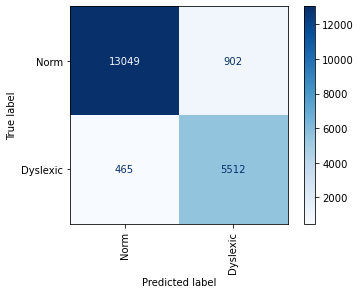

In [54]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [64]:
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
y_test_ = encoder.fit_transform(y_test.reshape(-1, 1))

y_test_

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [66]:

sklearn.metrics.roc_auc_score(y_test_, 
                              mdl.predict_proba(x_test),
                              # multi_class="ovr",
                              average="weighted")




0.9849162189319445

- 




In [67]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [68]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [69]:


shap_values = explainer(x_test)




Permutation explainer: 19929it [58:12,  5.69it/s]                                                                                                                    


In [70]:


print("Shap values are determined!")



Shap values are determined!


In [71]:


y_test.shape, x_test.shape, shap_values.values.shape



((19928,), (19928, 13), (19928, 13))

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



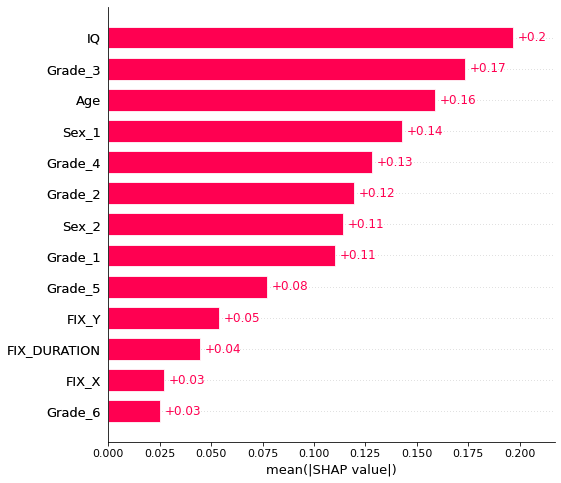

In [72]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




- The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.
- Althoght the remaining features have less significant SHAP values, still they all plan a role in predicting class labels.

- More info on beeswarm-bar plot 

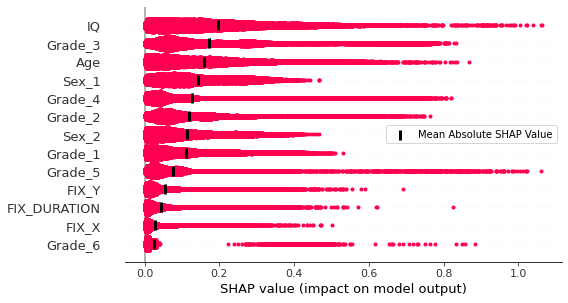

In [73]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

In addition to observe the same pattern on the relative importannce of features, one can observe that:

- There are quite a few sixth grade participants with very high SHAP values despite of its low MAS value in general.

- 



### SHAP Beeswarm Plots


- Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

- The points are distributed horizontally along the x-axis according to their SHAP value. In places where there is a high density of SHAP values, the points are stacked vertically. Examining how the SHAP values are distributed reveals how a variable may influence the model's predictions.

- The colour bar corresponds to the raw values (not to be confused with the SHAP values) of the variables for each instance (i.e. point) on the graph. If the value of a variable for a particular instance is relatively high, it appears as a red dot. Relatively low variable values appear as blue dots. Examining the color distribution horizontally along the x-axis for each variable provides insights into the general relationship between a variable's raw values and its SHAP values.


- These (the columns) are the input variables, ranked from top to bottom by their mean absolute SHAP values for the entire dataset. Note: this ranking is exactly the same as for the bar plot.



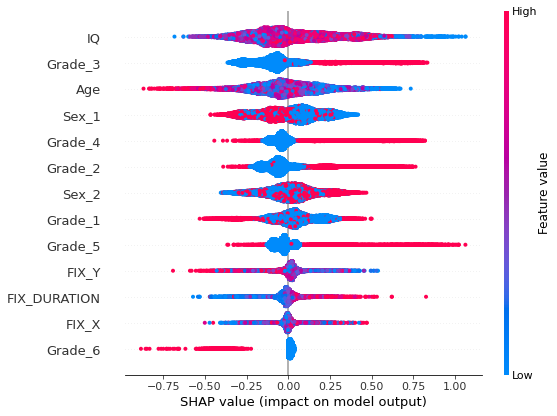

In [74]:

shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




- None-female (male) students have the highest negative SHAP values, implying the significance of this feature on prediction results. 


- Only the two extremes of students' "IQ" have direct impacts models prediction.


- Similar to IQ features, only the two extremes of "Age" feature plays an important role in models prediction.


- Most of the 3rd and 4th grade students, unlike the rest of grades, have high SHAP values which demostrates the importance of these two features.


- Fixation along Y-axis is more important than X-axis. 


- The 6th grade has no low impact on model's prediction result. 





### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

FixedFormatter should only be used together with FixedLocator


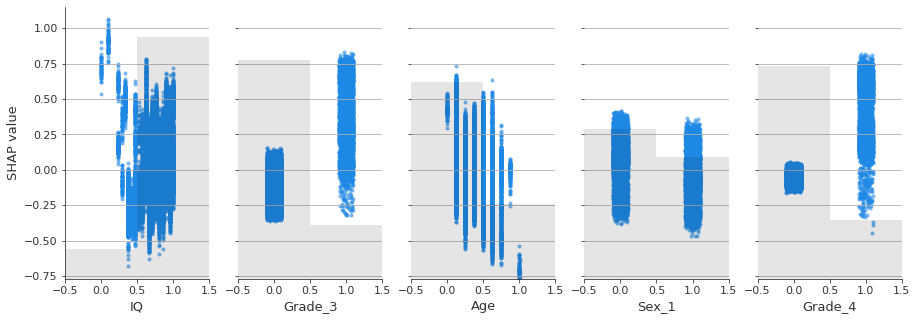

In [75]:


n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")




- The vertical spread of SHAP values at a fixed raw variable value is due to interaction effects with other variables. For example, here we see that sex_1 equal to unity (female) can have SHAP values that range from $-0.6 to 0.15$ depending on the other data for those particular instances. 


- The shapes of the distributions of points provide insights into the relationship between a variable's values and its SHAP values. We cannot see any specific relation between any individual feature and its importance (its SHAP values).



In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


In [ ]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [ ]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



n_size = 5
np.random.seed(43)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [ ]:
normals_rnd



In [ ]:
at_risks_rnd


In [ ]:

dyslexics_rnd


In [ ]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

In [ ]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

In [ ]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    